# [Introduction](https://www.ml4devs.com/articles/mlops-machine-learning-life-cycle/)
---

## Background

The Dutch housing market has been very saturated. People by property to rent to others, and people who wish to buy can't seem to find a home to purchase for their own. Others even more so, desire the freedom to more easily move between places. Whatever the reason you want _or_ have to get rental housing: An even playing field on the housing market would do well for everyone.

Roald ([@Bureauhalt](https://github.com/Roald1519166)) has made a [scrapper](https://github.com/Roald1519166/Scraper) to collect data about the rental housing market. The goal is to get more insights into the activity on the housing market, as to facilitate better decision making when attempting to find a place to live.

My ([@Blazoned](https://github.com/Blazoned)) personal stakes in this project are to find out what kind of insights can be acquired from the data collected. I will be working on creating a model to predict how long rental houses will be available on the market. I expect geocoding the address data might make for a better feature to determine availability duration. Using a time series based model might also prove beneficial given the housing market might express a certain seasonality within its given features.
I'm personally also interested to look at the potential of time series analysis to extract data potential from the given data set, and to have an interactive map at my disposal to explore the insights of this data in a more intuitive manner.

## Goal

### Statement
The goal of this particular notebook, is to determine availability of rental houses on the market.

### Methods
To do this, first data is collected from the source. Each time this notebook is run, the most recent data will be acquired. Additional data may be added to the core data set, as long as any extension to the data is based on information already present in the original source data. This data is curated to determine the data quality and to examine, if any, what steps are needed to improve data quality to allow for more practical use of the given data. After the data has been collected and reviewed, the data is further cleaned and transformed for use in machine learning models. The data is then validated for such use and compared to its state before this data transformation process.

Several model techniques are applied to the data to determine which techniques would be most beneficial based on a time-to-quality ratio. The most promising techniques are used to build models with. For these data modeling techniques feature selection and hyper parameter tuning will be applied. The found results will be used for the actual model training and validation procedure. The resulting models will be tested and analysed for usability in real life scenarios. Edge cases will be identified where prediction might not be reliable, accompanied with an advise about how to deal with these situations.

Based on the models and their usability, a deployment is suggested that should also attempt to resolve edge cases which should not be handled by the chosen model for deployment.


## Notebook Initialisation
```{important}
If you're reading this notebook in a raw format:
Install the Jupyterlab-MyST plugin and run these scripts before any other Python scripts are run, and before exporting this notebook.

The first script below loads any important dependencies into the active kernel. Run this script the first time you open this notebook before attempting to run any other part of the notebook. It sets Matplotlib to display its content in this notebook, loads Tensorboard if available in your Jupyter notebook environment and displays which cpus and gpus are available to you for use with Tensorflow. Use of Tensorflow and SciKit-Learn is assumed in this script, however you are encouraged to write your own version of this notebook using PyTorch and/or any other desired libraries.

The second script presented below is required for readability of this notebook. If it is not run, formatting of this notebook might look strange.
```

In [30]:
import os
import datetime

import pandas as pd
import numpy as np
import pyarrow as pa
from matplotlib import pyplot as plt
import seaborn as sns
import shap

import tensorflow as tf

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from xgboost import XGBRegressor

import statsmodels.api as sm
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

%matplotlib inline
%load_ext tensorboard

_devices = [f'{device.device_type}: {device.name}' for device in tf.config.list_physical_devices()]
print('\nTensorflow has access to the following active devices:\n  -', '\n  - '.join(_devices))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard

Tensorflow has access to the following active devices:
  - CPU: /physical_device:CPU:0
  - GPU: /physical_device:GPU:0


In [5]:
%%html
<style>
table {align:left; display:block}
</style>

# Data Acquisition
---

The most import parameter for successful machine learning is the quality of the data. During the data acquisition step the data is collected from its [source as a raw csv file](https://raw.githubusercontent.com/Roald1519166/Scraper/main/Data/huurwoningentotaalinactieftot.csv), the reliability of the source is analysed according to the [FAIR principals](https://www.go-fair.org/fair-principles/) and the quality of the data is validated according to the data quality conventions as described in [appendix A of this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5982846/#app-a.l.a.atitle) by Callahan et al. (2017).

The reliability is validated to express to what degree others who are unfamiliar with the data set can trust the data source, and if the meta data provided supports their understanding of the data set. Accountability for the data source is most important to be able to produce an equally trustworthy machine learning model.
The data quality is validated to make sure the data will provide quality information from which a machine learning model can interpret the underlying patterns captured in the data. If the quality of data is not properly maintained, any error will affect the machine learning process and negatively impact any reliability of any produced models.

## Collect

The [data source files](https://github.com/Roald1519166/Scraper/tree/main/Data) available from the [scraper repository](https://github.com/Roald1519166/Scraper) contain all scraped rental properties since 2022-11-20. There are different types of data sources as described in {numref}`table %s <data-sources>`.

```{list-table} Data source types
:header-rows: 1
:name: data-sources

* - Filename
  - Formats
  - Contents
* - _huurwoningentotaalinactieftot_
  - [csv](https://raw.githubusercontent.com/Roald1519166/Scraper/main/Data/huurwoningentotaalinactieftot.csv) | [xlsx](https://raw.githubusercontent.com/Roald1519166/Scraper/main/Data/huurwoningentotaalinactieftot.xlsx)
  - rental properties which are no longer available
* - _huurwoningentotaalvoorpowerbi_
  - [csv](https://raw.githubusercontent.com/Roald1519166/Scraper/main/Data/huurwoningentotaalvoorpowerbi.csv) | [xlsx](https://raw.githubusercontent.com/Roald1519166/Scraper/main/Data/huurwoningentotaalvoorpowerbi.xlsx)
  - rental properties which are still available
* - _huurwoningentotaal{timestamp}_
  - xlsx
  - rental properties which are still available as if the given timestamp in the filename
```

The goal of the machine learning model is to determine duration of availability of rental properties on the market. The [_huurwoningentotaalinactieftot_](https://raw.githubusercontent.com/Roald1519166/Scraper/main/Data/huurwoningentotaalinactieftot.csv)  data source has been chosen to achieve this goal as it contains all scraped properties that are no longer available on the market.

The headers used for each column of the data sources are consistent among the data source. These headers are each given in Dutch, and have been translated to English for use in this notebook. The contents of the data sources are described in {numref}`table %s <data-source-contents>`.

```{list-table} Data source contents
:header-rows: 1
:name: data-source-contents

* - Variable Name
  - Referenced Name
  - Description
* - **Plek**
  - _address_
  - The street address of a rental property. It does not contain the house number or apartment details.
* - **Wijk**
  - _district_
  - The district of a city in which the rental property is found.
* - **Postcode**
  - _postalCode_
  - The postal code at which the rental property is found. This will be the zip code if postal code is not applicable (e.g. United States of America).
* - **Plaatsnaam**
  - _city_
  - The name of the city or town in which the rental property is found.
* - **Prijs**
  - _rate_
  - The monthly rate the rental property costs in euros(€).
* - **Oppervlakte**
  - _livingArea_
  - The amount of living area the rental property provides in square meters(m$^2$).
* - **Kamers**
  - _rooms_
  - The amount of rooms available in the rental property.
* - **Interieur**
  - _interior_
  - In what state the interior of the property is being rented out. This indicates whether a rental property will come furnished, upholstered (unfurnished) or bare. (Possible values: _Gemeubileerd_, _Gestoffeerd_, _Kaal_)
* - **Link**
  - _link_
  - The url from which the rental offer has been sourced.
* - **AangebodenSinds**
  - _offerSince_
  - The date at which the rental offer was made available.
* - **Beschikbaarheid**
  - _availableFrom_
  - The earliest possible effective date at which the rental property can be rented.
* - **Woningtype**
  - _housingType_
  - What type of property is being rented out. This indicates whether a rental property is a room, studio, apartment or house (Possible values: _Kamer_, _Studio_, _Appartement_, _Huis_)
* - **Bouwjaar**
  - _constructionYear_
  - The year during which the construction of the rental property was completed.
* - **Parkeren**
  - _parkingAvailable_
  - Whether the offer has explicitly made notice of parking availability with the rental property, indicated by either yes or no (Possible values: _Ja_, _Nee_)
* - **Updated**
  - _scrapingDate_
  - The date and time at which this record has been scraped to be appended to the data set.
* - **Status**
  - _status_
  - The current status of a rental property since the last time the scraper was active. This indicates whether a property just became available, is still active, or is no longer available (Possible values: _New_, _Active_, _Inactive_)
* - **Land**
  - _country_
  - The country in which the rental property is located.
* - **Outdated**
  - _offerUntil_
  - The date at which the rental property was no longer available. This column is only available in the 'huurwoningentotaalinactieftot' data source.
```

The script below will load the data into memory. The column names have been changed according to {numref}`table %s <data-source-contents>`. The pandas data frame makes use of the default numpy datatype backend, as the pyarrow backend cannot produce a mean or standard deviation for the '_rate_' variable in the data set. Numeric variables have been converted to its applicable scale. The '_country_' variable has been converted to a categorical object also, as the data set does not have any existing value for this variable.

In [7]:
columns = ['address', 'district', 'postalCode', 'city', 'rate', 'livingArea', 'rooms', 'interior', 
           'link', 'offerSince', 'availableFrom', 'housingType', 'constructionYear', 'parkingAvailable', 'scrapingDate', 'status', 'country', 'offerUntil']
data = pd.read_csv('https://raw.githubusercontent.com/Roald1519166/Scraper/main/Data/huurwoningentotaalinactieftot.csv', low_memory=False, header=0, names=columns)
# data = data.convert_dtypes(dtype_backend='pyarrow')

data['rate'] = pd.to_numeric(data['rate'], errors='coerce', downcast='float')
data['livingArea'] = pd.to_numeric(data['livingArea'], errors='coerce', downcast='float')
data['rooms'] = pd.to_numeric(data['rooms'], errors='coerce', downcast='integer')
data['constructionYear'] = pd.to_numeric(data['constructionYear'], errors='coerce', downcast='integer')

data['country'] = data['country'].astype('object')

## Curate



### Fair-analysis
[explanation](https://www.go-fair.org/fair-principles/)



#### [Findable](https://www.go-fair.org/fair-principles/#:~:text=FAIRification%20Framework.-,Findable,-The%20first%20step)

F1: Partial globally unique identifier

F2: No descriptive information about the context, quality and condition, or characteristics of the data. (not explicitly described contextual data -> How and when data was acquired)

F3: The identifier is the meta-data. Technically identifier and meta-data are linked.

F4: Registered and publicly available on GitHub, can be searched but isn't easily discoverable on the service without prior knowledge of its existence.

#### [Accessible](https://www.go-fair.org/fair-principles/#:~:text=a%20searchable%20resource-,Accessible,-Once%20the%20user)

A1: No specialised protocol required. Https request to a github repository.

A1.1: Https protocol is open, free and universally implemented standard for web browsing since May 2000 as specified in RFC2818 when it was https was made to use the new SSL based TLS protocol.

A1.2: If the GitHub repository would have been private authentication could have been implemented for accessing the data. As if now, such is irrelevant for the assessment of A1. 

A2: Since the meta-data is highly linked to the data itself, there is no meta-data persistence guaranteed when the data itself has been removed.

#### [Interoperable](https://www.go-fair.org/fair-principles/#:~:text=no%20longer%20available-,Interoperable,-The%20data%20usually)

I1: The data is both available in the open file standards csv and xlsx having a clear formal specification each. The data can even be used in scenarios which it has not been designed for if so desired.

I2: Vocabulary not explicitly described, but most terminology is used in common tongue. Description of columns recommended.

I3: Data is sourced from rental housing websites. The entries are directly associated with its source via a url. Could be better explained, but citations are available where citations are needed.

#### [Reusable](https://www.go-fair.org/fair-principles/#:~:text=other%20(meta)data-,Reusable,-The%20ultimate%20goal)

R1: The data has no contextual information about itself nor its labels (columns) except for date of creation of the new data source. It doesn't assume a specific data consumer identity, but does not properly support a general data consumer either:
- Scope of the data not defined (purpose of data collection/generation)
- Particularities or limitations of the data not defined where necessary
- Methods of acquisition of the data are not clearly stated
- Data is unrefined, which is not stated in its metadata
- Fields/columns are not explained, and knowledge is assumed to be inherent
- Data versioning and archiving is not explicitly documented

R1.1: No data usage license defined despite the data being publicly accessible. Not clear to both human _and_ machine.

R1.2: Source of data is defined in the data itself, but the process of data acquisition is not explained.

R1.3: Cannot judge community standards within this data domain. Most labels/fields are easily understandable and needn't have much explanation, a few such labels do not have a domain specific identity and are vague to interpret.

### Data quality analysis



In [99]:
data.head(10)

,address,district,postalCode,city,rate,livingArea,rooms,interior,link,offerSince,availabilityFrom,housingType,constructionYear,parkingAvailable,scrapingDate,status,country,offerUntil
0,Nassaustraat,Nassaubuurt,5046 NS,Tilburg,1180.0,59.0,3.0,Gestoffeerd,https://www.huurwoningen.nl/huren/tilburg/1079...,3 weken,Per 30-12-2022,Appartement,1957.0,Nee,2022-11-20,Inactive,NaN,2022-11-28
1,Korte Mare,Noordvest,2312 NN,Leiden,745.0,30.0,1.0,Gestoffeerd,https://www.huurwoningen.nl/huren/leiden/13259...,19-11-2022,Per 12-12-2022,Appartement,1760.0,Nee,2022-11-20,Inactive,NaN,2022-11-28
2,Demertstraat,Heer,6227 AR,Maastricht,805.0,36.0,2.0,Gestoffeerd,https://www.huurwoningen.nl/huren/maastricht/1...,19-11-2022,Per 01-01-2023,Appartement,NaN,Nee,2022-11-20,Inactive,NaN,2022-11-28
3,Beeltplein,Boschstraatkwartier,6211 AM,Maastricht,1195.0,79.0,3.0,Gestoffeerd,https://www.huurwoningen.nl/huren/maastricht/1...,19-11-2022,Per 01-01-2023,Appartement,NaN,Nee,2022-11-20,Inactive,NaN,2022-11-28
4,Spoorstraat,Winkelcentrum,5911 KJ,Venlo,750.0,40.0,2.0,NaN,https://www.huurwoningen.nl/huren/venlo/132592...,19-11-2022,Per direct,Appartement,1962.0,Nee,2022-11-20,Inactive,NaN,2022-11-28
5,Wycker Grachtstraat,Wyck,6221 CW,Maastricht,438.0,22.0,1.0,Gestoffeerd,https://www.huurwoningen.nl/huren/maastricht/1...,19-11-2022,Per 01-01-2023,Kamer,NaN,Ja,2022-11-20,Inactive,NaN,2022-11-28
6,Kommel,Kommelkwartier,6211 NX,Maastricht,321.0,13.0,1.0,Gestoffeerd,https://www.huurwoningen.nl/huren/maastricht/1...,19-11-2022,Per 01-01-2023,Kamer,NaN,Ja,2022-11-20,Inactive,NaN,2022-11-28
7,Regentesselaan,Haag Koningsplein en omgeving,2562 CW,Den Haag,820.0,41.0,2.0,Gestoffeerd,https://www.huurwoningen.nl/huren/den-haag/132...,18-11-2022,Per 15-12-2022,Appartement,1898.0,Ja,2022-11-20,Inactive,NaN,2022-11-28
8,van Sevenbergestraat,Voorburg Noord noord,2274 PJ,Voorburg,1550.0,64.0,4.0,Gestoffeerd,https://www.huurwoningen.nl/huren/voorburg/132...,18-11-2022,Per 01-12-2022,Appartement,1929.0,Nee,2022-11-20,Inactive,NaN,2022-11-28
9,Columbusstraat,Haag Valkenboskwartier,2561 AJ,Den Haag,1150.0,56.0,1.0,Gestoffeerd,https://www.huurwoningen.nl/huren/den-haag/132...,18-11-2022,Per 09-12-2022,Appartement,NaN,Nee,2022-11-20,Inactive,NaN,2022-11-28


In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145723 entries, 0 to 145722
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   address           145723 non-null  object 
 1   district          145723 non-null  object 
 2   postalCode        145723 non-null  object 
 3   city              145723 non-null  object 
 4   rate              145566 non-null  float32
 5   livingArea        145723 non-null  float32
 6   rooms             134192 non-null  float64
 7   interior          116189 non-null  object 
 8   link              145723 non-null  object 
 9   offerSince        145504 non-null  object 
 10  availabilityFrom  145504 non-null  object 
 11  housingType       145504 non-null  object 
 12  constructionYear  90581 non-null   float64
 13  parkingAvailable  145504 non-null  object 
 14  scrapingDate      145723 non-null  object 
 15  status            145723 non-null  object 
 16  country           0 

In [101]:
print("# Nummerical data")
data.describe(include=None)

# Nummerical data


,rate,livingArea,rooms,constructionYear
count,145566.000000,145723.000000,134192.000000,90581.000000
mean,1436.868164,77.924408,2.892296,1951.925625
std,780.172607,42.698353,1.364149,112.935101
min,65.000000,1.000000,1.000000,0.000000
25%,950.000000,50.000000,2.000000,1926.000000
50%,1295.000000,73.000000,3.000000,1965.000000
75%,1750.000000,100.000000,4.000000,2003.000000
max,17500.000000,968.000000,19.000000,2024.000000


<Axes: xlabel='constructionYear', ylabel='Count'>

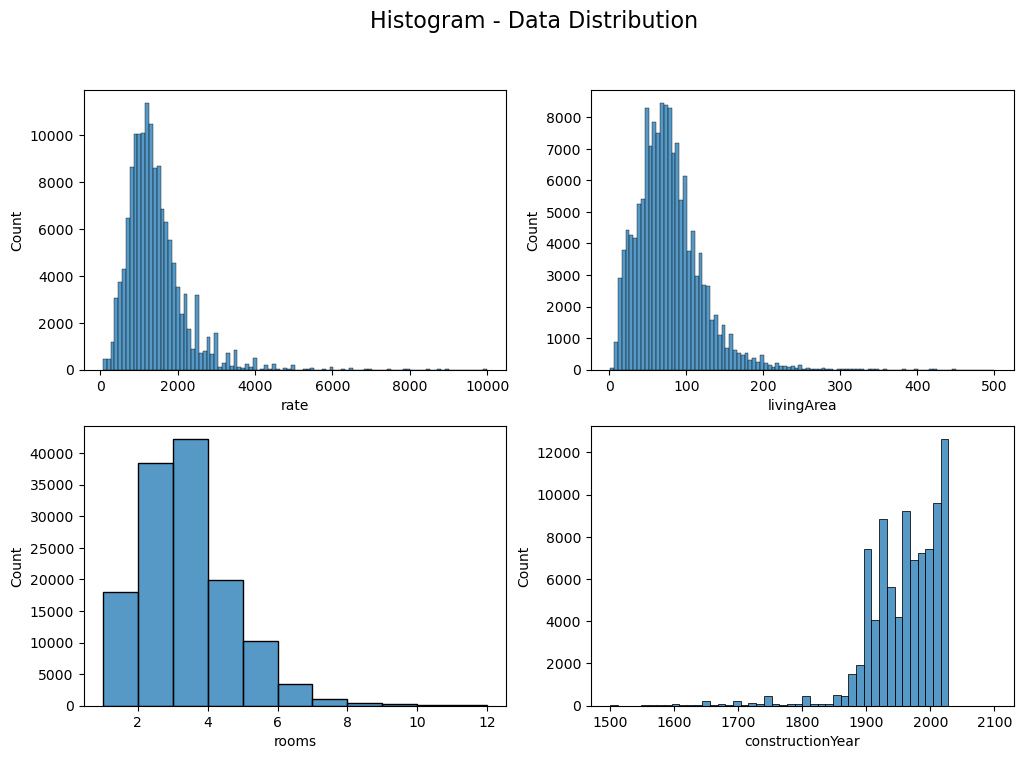

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Histogram - Data Distribution', fontsize=16)

sns.histplot(ax=axes[0, 0], data=data, x='rate', bins=100, binrange=[65, 10000])
sns.histplot(ax=axes[0, 1], data=data, x='livingArea', bins=100, binrange=[1, 500])
sns.histplot(ax=axes[1, 0], data=data, x='rooms', bins=11, binrange=[1, 12])
sns.histplot(ax=axes[1, 1], data=data, x='constructionYear', bins=50, binrange=[1500, 2100])

<Axes: ylabel='constructionYear'>

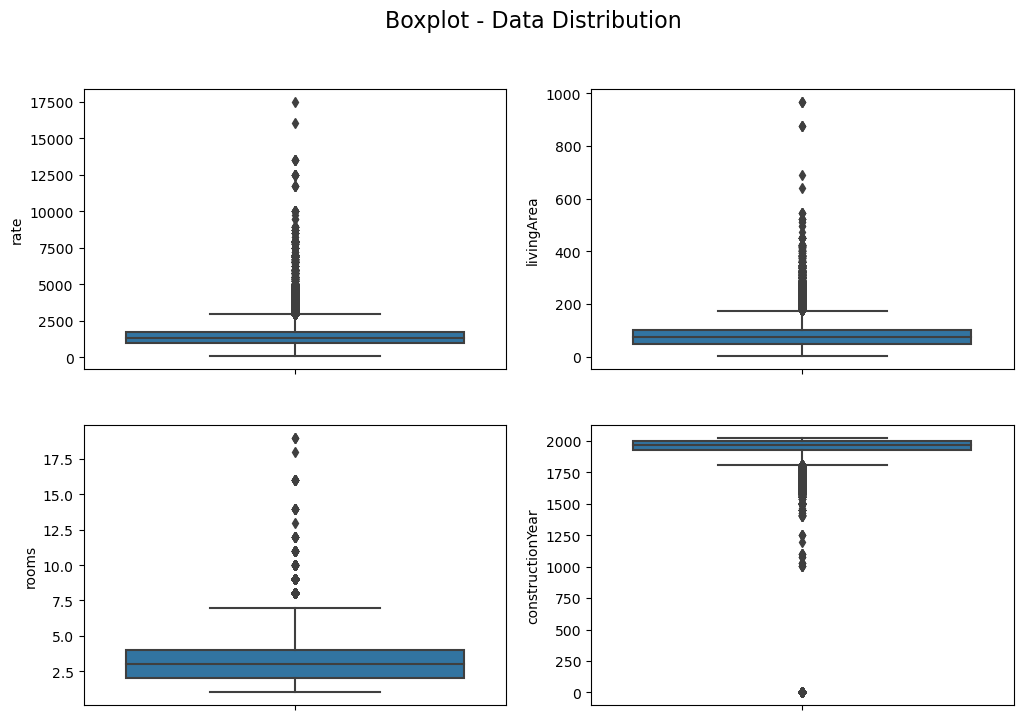

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Boxplot - Data Distribution', fontsize=16)

sns.boxplot(ax=axes[0, 0], data=data, y='rate')
sns.boxplot(ax=axes[0, 1], data=data, y='livingArea')
sns.boxplot(ax=axes[1, 0], data=data, y='rooms')
sns.boxplot(ax=axes[1, 1], data=data, y='constructionYear')

In [123]:
print("# Outliers data (std > 3.0)")
std = data.std(numeric_only=True)
mean = data.mean(numeric_only=True)

lower_bound = mean - (3*std)
upper_bound = mean + (3*std)

outliers = std.copy()
outliers['rate'] = len(data[(data['rate'] < lower_bound['rate']) | (data['rate'] > upper_bound['rate'])])
outliers['livingArea'] = len(data[(data['livingArea'] < lower_bound['livingArea']) | (data['livingArea'] > upper_bound['livingArea'])])
outliers['rooms'] = len(data[(data['rooms'] < lower_bound['rooms']) | (data['rooms'] > upper_bound['rooms'])])
outliers['constructionYear'] = len(data[(data['constructionYear'] < lower_bound['constructionYear']) | (data['constructionYear'] > upper_bound['constructionYear'])])

outliers.head()

# Outliers data (std > 3.0)


rate                2120.0
livingArea          1695.0
rooms               1899.0
constructionYear     536.0
dtype: float64

<Axes: title={'center': 'Correlation Matrix'}>

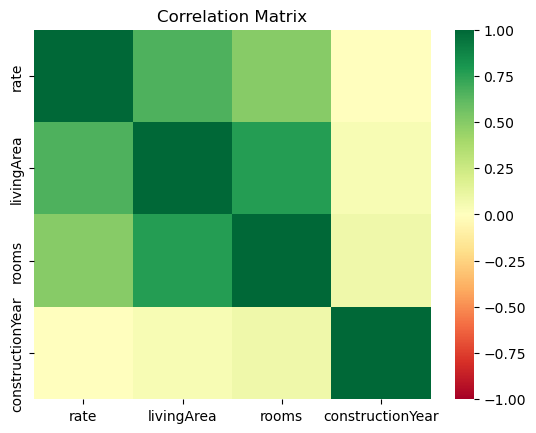

In [116]:
plt.title('Correlation Matrix')
sns.heatmap(data=data.corr(numeric_only=True), vmin=-1, vmax=1, cmap='RdYlGn')

In [39]:
print("# Categorical data")
data.describe(include=['string'])

# Categorical data


,address,district,postalCode,city,interior,link,offerSince,availabilityFrom,housingType,parkingAvailable,scrapingDate,status,country,offerUntil
count,145723,145723,145723,145723,116189,145723,145504,145504,145504,145504,145723,145723,0,145723
unique,14146,5089,26448,1183,3,48983,378,458,4,2,360,1,0,358
top,Kerkstraat,Binnenstad,3811 HM,Amsterdam,Gestoffeerd,https://www.huurwoningen.nl/huren/zwijndrecht/...,2 weken,Per direct,Appartement,Nee,2022-11-20,Inactive,NaN,2022-11-30
freq,506,2985,386,17382,62172,29,33171,70577,107328,116083,2738,145723,NaN,1420


In [197]:
print("# Interior categories")
data.groupby('interior').nunique().max(axis=1)

# Interior categories


interior
Gemeubileerd    13984
Gestoffeerd     21014
Kaal             4141
dtype: int64

In [199]:
print("# Housing type categories")
data.groupby('housingType').nunique().max(axis=1)

# Housing type categories


housingType
Appartement    36081
Huis            9351
Kamer           2266
Studio          1241
dtype: int64

In [200]:
print("# Parking categories")
data.groupby('parkingAvailable').nunique().max(axis=1)

# Parking categories


parkingAvailable
Ja      9872
Nee    39164
dtype: int64

In [201]:
print("# Status categories")
data.groupby('status').nunique().max(axis=1)

# Status categories


status
Inactive    48983
dtype: int64

[0, 175, 350]


<Axes: title={'center': 'Lineplot - Timeline Data Collection'}, xlabel='scrapingDate'>

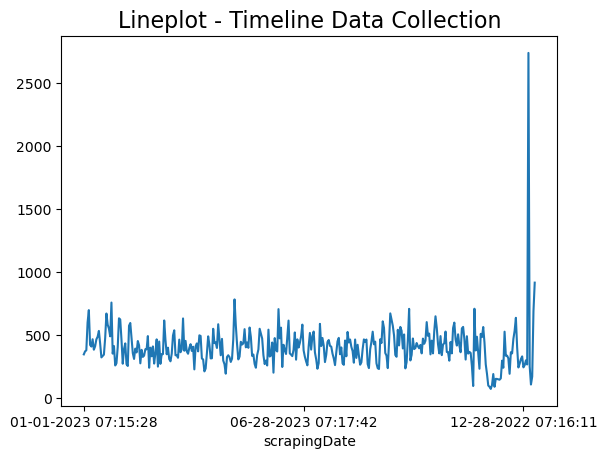

In [194]:
plt.title('Lineplot - Timeline Data Collection', fontsize=16)

timeline = data.groupby('scrapingDate').count().max(axis=1)
plot = sns.lineplot(data=timeline, x=timeline.index, y=timeline, legend='brief')

ticks = len(timeline)
ticks = [tick for tick in range(ticks) if tick % 175 == 0]
print(ticks)

plot.set_xticks(ticks)
plot

# Data Cleaning
---


In [10]:
df_rentals = data.copy()

## Clean



## Transform



In [ ]:
timecols = ['Updated','Outdated']

for col in timecols:
    for i in range(len(df)):
        try:
            df[col][i].split(" ")[1]
            df.at[i, col] = pd.to_datetime(df[col][i].split(" ")[0], format="%m-%d-%Y")
        except:
            df.at[i, col] = pd.to_datetime(df[col][i], format="%Y-%m-%d")
    df[col] = pd.to_datetime(df[col], format="%Y-%m-%d")

df["DateDiff"] = df["Outdated"] - df["Updated"]
df["DateDiff"] = df['DateDiff'] / np.timedelta64(1, 'D')

df = df.drop(columns=['AangebodenSinds'])

for i in range(len(df)):
    try:
        df['Beschikbaarheid'][i].split("Per ")
        if df['Beschikbaarheid'][i].split("Per ")[1] == 'direct':
            print(0)
            df.at[i, 'Beschikbaarheid'] = 0
        else:
            date = pd.to_datetime(df['Beschikbaarheid'][i].split("Per ")[1], format="%d-%m-%Y")
            df.at[i, 'Beschikbaarheid'] = (date - df['Updated'][i]).days
    except:
        print(0)
        df.at[i, 'Beschikbaarheid'] = 0
df['Beschikbaarheid'] = df['Beschikbaarheid'].astype("int")


## Validate



In [ ]:
df.info()

##Lists maken voor verschillende type kolommen
df['Woningtype'] = df['Woningtype'].astype('category')

num_columns = df.dtypes[df.dtypes != 'object'].index
cat_columns = df.dtypes[df.dtypes == 'object'].index

print('Numerieke kolommen: {}' .format(num_columns))
print('Aantal numerieke kolommen: {}' .format(len(num_columns)))
print()
print('Categorische kolommen: {}' .format(cat_columns))
print('Aantal categorische kolommen: {}' .format(len(cat_columns)))



# Model Exploration
---


## Techniques



In [ ]:
# XGBoost
model = XGBRegressor(verbosity=0, maxdepth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
n = len(y_test)
k = len(X_test.columns)

#Uitrekenen Adj R2
adj_r2_score = 1-(((1-r2)*(n-1))/(n-k-1))

print("Mean Squared Error:")
print(mean_squared_error(y_test, y_pred))
print()
print("Root Mean Squared Error:")
print(mean_squared_error(y_test, y_pred, squared = False))
print()
print("Test R2-Score:")
print(r2_score(y_test, y_pred))
print()
print("Training R2-Score:")
y_train_pred = model.predict(X_train)
print(r2_score(y_train, y_train_pred))
print()
print("Adjusted R2-Score:")
print(adj_r2_score)

plt.scatter(y_test, y_pred)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('R2: ' + str(r2_score(y_test, y_pred)))
plt.plot([y.min(),y.max()],[y.min(), y.max()],'k--',lw=4)

explainer = shap.explainers.Tree(model)
shap_values = explainer(X_test)
# shap.summary_plot(shap_values, X_test, show=False)
shap.summary_plot(shap_values, X_test, plot_type='violin')

fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(10)
plt.show()

explainer = shap.explainers.Tree(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, show=False)
# shap.summary_plot(shap_values, X_test, plot_type='violin')

fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(10)
plt.show()

## Feature Selection



In [ ]:
X = df_scaled.loc[:, df_scaled.columns != voorspellen]
y = df_scaled[voorspellen]
for x in afhankelijk:
    X = X.drop([x], axis = 1 )
    
X_train, X_test, y_train, y_test = train_test_split(X , y  , test_size = 0.20 , random_state = 0)

X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm).fit()
print(lr.summary())

## Feature Transformation



## Parameter Tuning



# Model Training
---


## Training



## Validation



# Model Evaluation
---


## Testing



## Analysis



## Deployment

